# Fuel Station Example

![image](../figures/fuel_station.png)

In [6]:
# Fuel Station Example

import simpy
from typing import List
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt

class Vehicle():
    def __init__(
            self, 
            id, 
            charge, 
            capacity
            ):

        self.id = id
        self.charge = charge 
        self.capacity = capacity


class Employee():
    def __init__(self, env, id):
        self.env = env
        self.id = id
        self.idle = True



class Pump():
    def __init__(self, env:simpy.Environment, id, pump_speed=0.89):
        self.env = env
        self.id = id
        self.pump_speed = pump_speed
        self.entry_queu = []
        self.process_queu = []
        self.exit_queu = []
        self.employee = None
        self.idle = True


    def vehicle_entered(self, vehicle:Vehicle):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} entered Pump {self.id}")
        yield self.env.timeout(1)
        self.entry_queu.append(vehicle)
        # Register queu lenght
        self.env.record_metric(name='queus', value={
            "pump":f"{type(self).__name__}-{self.id}",
            "entry_queu":len(self.entry_queu),
            "time":self.env.current_date
            })


    def assign_employee(self, employee):
        print(f"{self.env.current_date} - Employee {employee.id} assigned to Pump {self.id}")
        yield self.env.timeout(1)
        self.employee = employee
        

    def prepare_charge_vehicle(self, vehicle:Vehicle, employee:Employee):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} preparing in Pump {self.id} by Employee {employee.id}")

        time = np.random.triangular(1*60,3*60,5*60)
        yield self.env.timeout(time)
        self.env.record_metric(name='process_time', value={
            "node":f"{type(self).__name__}-{self.id}",
            "process_name":"prepare_charge",
            "process_time":time,
            "time":self.env.current_date
            })

        self.employee = None
        employee.idle = True
        self.entry_queu.remove(vehicle)
        self.process_queu.append(vehicle)



    def charge_vehicle(self, vehicle):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} charging in Pump {self.id}")
        self.idle = False
        quantity = vehicle.capacity*vehicle.charge
        time = quantity/self.pump_speed
        yield self.env.timeout(time) 
        self.env.record_metric(name='process_time', value={
            "node":f"{type(self).__name__}-{self.id}",
            "process_name":"charge",
            "process_time":time,
            "time":self.env.current_date
            })

        self.process_queu.remove(vehicle)
        self.exit_queu.append(vehicle)
        self.idle = True

    def prepare_exit_vehicle(self, vehicle:Vehicle, employee:Employee):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} pre-exiting Pump {self.id} by Employee {employee.id}")
        time = np.random.triangular(1*60,3*60,5*60)
        yield self.env.timeout(time)
        self.env.record_metric(name='process_time', value={
            "node":f"{type(self).__name__}-{self.id}",
            "process_name":"prepare_exit_charge",
            "process_time":time,
            "time":self.env.current_date
            })

        self.employee = None
        employee.idle = True
        self.exit_queu.remove(vehicle)
    

    def vehicle_exited(self, vehicle):
        print(f"{self.env.current_date} - Vehicle {vehicle.id} exited Pump {self.id}")
        yield self.env.timeout(1)


    def __call__(self):
        while True:            
            if self.employee is not None:
                if len(self.exit_queu)>0:
                    vehicle = self.exit_queu[0]
                    employee = self.employee
                    yield self.env.process(self.prepare_exit_vehicle(vehicle, employee))
                    yield self.env.process(self.vehicle_exited(vehicle))
                else:
                    vehicle = self.entry_queu[0]
                    employee = self.employee
                    yield self.env.process(self.prepare_charge_vehicle(vehicle, employee))
                    yield self.env.process(self.charge_vehicle(vehicle))
            else:
                yield self.env.timeout(1) 
                


    
class FuelStation():
    
    def __init__(self, env:simpy.Environment, pumps:List[Pump], employees:List[Employee], vehicles:List[Vehicle]=[]):
        self.env = env
        self.pumps = pumps
        self.employees = employees
        self.vehicles = vehicles
        self.total_arrives = len(vehicles)

    def assign_employees(self):
        while True:
            sorted_pumps = sorted(self.pumps, key=lambda p: len(p.entry_queu)+len(p.process_queu)) 
            for p in sorted_pumps:
                if p.idle and (len(p.entry_queu)+len(p.exit_queu))>0 :
                    for e in self.employees:
                        if e.idle:
                            e.idle = False
                            self.env.process(p.assign_employee(e))
                            yield self.env.timeout(1)
                        else:
                            yield self.env.timeout(1)
                else:
                    yield self.env.timeout(1) 


    def assign_vehicles(self):
        while True:
            if len(self.vehicles)>0:
                sorted_pumps = sorted(self.pumps, key=lambda p: len(p.entry_queu)+len(p.process_queu))
                pump = sorted_pumps[0]
                vehicle = self.vehicles.pop(0)
                print(f"{self.env.current_date} - Vehicle {vehicle.id} assigned to Pump {pump.id} total queu {len(pump.entry_queu)+len(pump.process_queu)}")
                yield env.process(pump.vehicle_entered(vehicle))
                yield self.env.timeout(1)
            else:
                yield self.env.timeout(1) 

    def vehicle_arrival(self, interarrival_time=7*60):
        while True:
            yield self.env.timeout(np.random.poisson(lam=interarrival_time))
            vehicle_id = self.total_arrives

            charge = np.random.triangular(left=.0, mode=.2, right=.8) 
            capacity = np.random.choice(a=[45,65],p=[0.8,0.2])
            
            vehicle = Vehicle(id=vehicle_id, charge=charge, capacity=capacity)
            self.vehicles.append(vehicle)
            print(f"{self.env.current_date} - New Vehicle {vehicle.id} arrived")
            self.total_arrives += 1

    def __call__(self, interarrival_time=7*60):
        for p in self.pumps:
            self.env.process(p())
        self.env.process(self.vehicle_arrival(interarrival_time))
        self.env.process(self.assign_vehicles())
        self.env.process(self.assign_employees())



class SimEnv(simpy.Environment):

    def __init__(self, start_date=None):
        super().__init__()

        self.start_date = (
            start_date if start_date 
            else datetime.datetime.now()
            ) 

        self.metrics = {}

    @property
    def current_date(self):
        return (
            datetime.timedelta(seconds = self.now) + 
            self.start_date
            )

    def add_metric(self, name, unit=None):
        self.metrics[name] = {
            "unit":unit,
            "name":name,
            "values":[]
        }

    def record_metric(self, name, value):
        self.metrics[name]['values'].append(value)



env = SimEnv()
env.add_metric("queus")
env.add_metric('process_time')

n_pumps = 4 # number of pumps
pump_speed = 0.11
n_employees = 1 # number of employees
n_vehicles = 0 # initial vehicles
interarrival_time = 6*60 # min*seg
sim_time = 1*24*60*60 # days*hours*minutes*seconds

pumps = [Pump(env=env, id = i, pump_speed=pump_speed) for i in range(n_pumps)]
employees = [Employee(env=env, id = i) for i in range(n_employees)]
vehicles = [Vehicle(id=i) for i in range(n_vehicles)]

fuel_station = FuelStation(
    env=env, 
    pumps=pumps, 
    employees=employees, 
    vehicles=vehicles
    )

fuel_station(interarrival_time)

env.run(until=sim_time) 

2022-07-07 12:40:15.531537 - New Vehicle 0 arrived
2022-07-07 12:40:15.531537 - Vehicle 0 assigned to Pump 0 total queu 0
2022-07-07 12:40:15.531537 - Vehicle 0 entered Pump 0
2022-07-07 12:40:19.531537 - Employee 0 assigned to Pump 0
2022-07-07 12:40:21.531537 - Vehicle 0 preparing in Pump 0 by Employee 0
2022-07-07 12:42:59.244216 - Vehicle 0 charging in Pump 0
2022-07-07 12:43:24.531537 - Employee 0 assigned to Pump 0
2022-07-07 12:43:26.396277 - Vehicle 0 pre-exiting Pump 0 by Employee 0
2022-07-07 12:45:18.565324 - Vehicle 0 exited Pump 0
2022-07-07 12:46:29.531537 - New Vehicle 1 arrived
2022-07-07 12:46:29.531537 - Vehicle 1 assigned to Pump 0 total queu 0
2022-07-07 12:46:29.531537 - Vehicle 1 entered Pump 0
2022-07-07 12:46:35.531537 - Employee 0 assigned to Pump 0
2022-07-07 12:46:36.565324 - Vehicle 1 preparing in Pump 0 by Employee 0
2022-07-07 12:51:27.558184 - Vehicle 1 charging in Pump 0
2022-07-07 12:52:22.531537 - New Vehicle 2 arrived
2022-07-07 12:52:22.531537 - Vehi

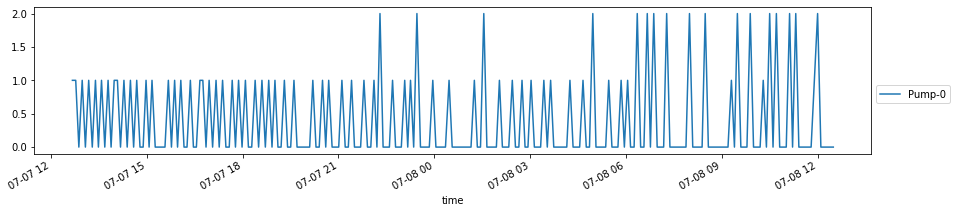

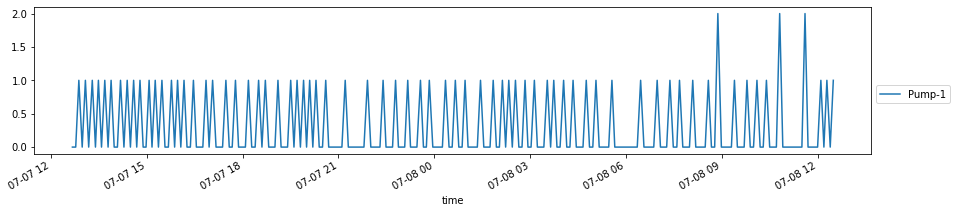

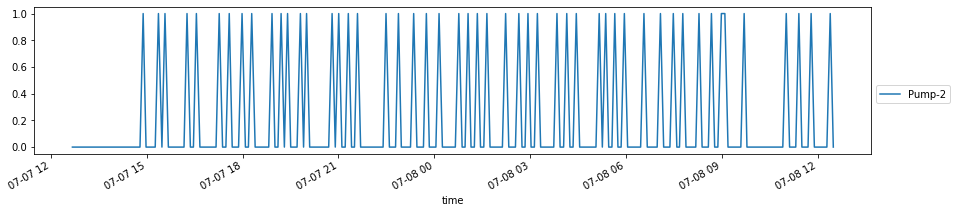

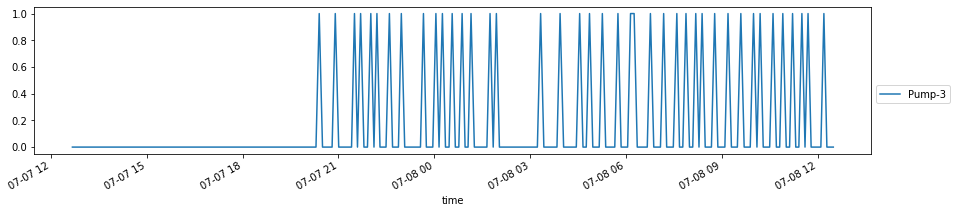

In [7]:
df = pd.DataFrame((env.metrics['queus']['values'])).pivot_table(
    index=['time'],
    columns='pump',
    values='entry_queu'
)

for col in df:
    plt.figure()
    df[col].fillna(0).plot(figsize=(15,3)).legend(bbox_to_anchor=(1, 0.5))

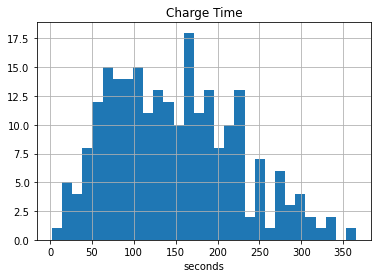

In [3]:
process_time_df = pd.DataFrame((env.metrics['process_time']['values']))

plt.figure()
process_time_df[process_time_df['process_name']=='charge']['process_time'].hist(bins=30)
plt.title("Charge Time")
plt.xlabel("seconds")
plt.show()

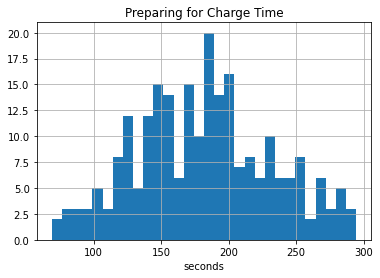

In [4]:
process_time_df[process_time_df['process_name']=='prepare_charge']['process_time'].hist(bins=30)
plt.title("Preparing for Charge Time")
plt.xlabel("seconds")
plt.show()

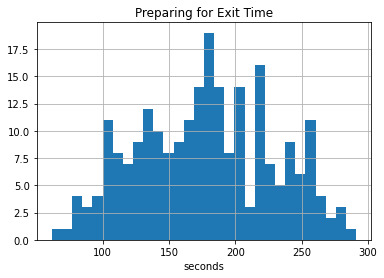

In [5]:
process_time_df[process_time_df['process_name']=='prepare_exit_charge']['process_time'].hist(bins=30)
plt.title("Preparing for Exit Time")
plt.xlabel("seconds")
plt.show()